In [1]:
import pandas as pd
file_path = 'bbc-news-data.csv'
df = pd.read_csv(file_path, delimiter='\t')

df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [3]:
print(f"Dataset size: {df.shape}")
print(df.columns)

Dataset size: (2225, 4)
Index(['category', 'filename', 'title', 'content'], dtype='object')


In [4]:
print(df['category'].describe())

count      2225
unique        5
top       sport
freq        511
Name: category, dtype: object


In [5]:
print(df['title'].describe())

count                                 2225
unique                                2096
top       Microsoft seeking spyware trojan
freq                                     2
Name: title, dtype: object


In [6]:
print(df['content'].describe())

count                                                  2225
unique                                                 2092
top        Microsoft has warned PC users to update their...
freq                                                      2
Name: content, dtype: object


In [7]:
category_distribution = df['category'].value_counts()
print(category_distribution)

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


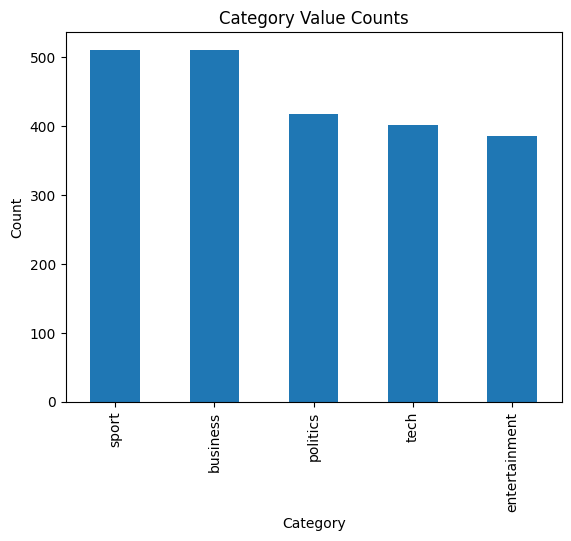

In [8]:
import matplotlib.pyplot as plt

category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Value Counts')

plt.show()

In [9]:
import re
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk import download
from nltk.stem import WordNetLemmatizer

download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #remove HTML tags and lowercase the text
    text = re.sub(r'<.*?>', '', text).lower()
    #remove non-word characters
    text = re.sub(r'[^\w\s]', '', text)
    
    #tokenize the text
    tokens = simple_preprocess(text)
    #lemmatize the tokens and remove stop words
    lemmatized_text = [lemmatizer.lemmatize(token) for token in tokens if token not in STOPWORDS]
    return lemmatized_text

#create new column in dataframe with cleaned text
df['processed_text'] = df['content'].apply(clean_text)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jasonjiang/nltk_data...


In [10]:
df.head()

,category,filename,title,content,processed_text
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[quarterly, profit, medium, giant, timewarner,..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[dollar, hit, highest, level, euro, month, fed..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[owner, embattled, russian, oil, giant, yukos,..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[british, airway, blamed, high, fuel, price, d..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[share, uk, drink, food, firm, allied, domecq,..."


In [12]:
# Calculate the length of each article
df['word_count'] = df['processed_text'].apply(len)


# Overall word count distribution
overall_word_count_distribution = df['word_count'].describe()
print("Overall Word Count Distribution:")
print(overall_word_count_distribution)


# Word count distribution per category
category_word_count_distribution = df.groupby('category')['word_count'].describe()
print("\nWord Count Distribution per Category:")
print(category_word_count_distribution)

df.head()

Overall Word Count Distribution:
count    2225.000000
mean      190.300674
std       110.557429
min        40.000000
25%       122.000000
50%       167.000000
75%       234.000000
max      1947.000000
Name: word_count, dtype: float64

Word Count Distribution per Category:
               count        mean         std   min    25%    50%    75%  \
category                                                                  
business       510.0  169.337255   68.880495  62.0  121.0  156.5  200.0   
entertainment  386.0  168.062176  121.580848  72.0  114.0  137.5  184.0   
politics       417.0  223.237410  133.961241  40.0  159.0  222.0  263.0   
sport          511.0  157.430528   91.351500  54.0   97.0  132.0  194.5   
tech           401.0  246.004988  108.312788  85.0  174.0  222.0  307.0   

                  max  
category               
business        457.0  
entertainment  1594.0  
politics       1947.0  
sport           837.0  
tech           1272.0  


,category,filename,title,content,processed_text,word_count
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[quarterly, profit, medium, giant, timewarner,...",217
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[dollar, hit, highest, level, euro, month, fed...",196
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[owner, embattled, russian, oil, giant, yukos,...",142
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[british, airway, blamed, high, fuel, price, d...",211
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[share, uk, drink, food, firm, allied, domecq,...",147
